# Analyzing CPST Students Affectation to Higher Schools

## Libraries and Data Imports

In [5]:
import holoviews as hv
from holoviews import opts, dim
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams['figure.dpi'] = 100

The data was obtained from a scanned copy of the list, the OCR operation was not accuratae 100% so some manual cleaning had to be done. You can dowload the data from this [link]("/concours-2022-ST.xlsx").

In [2]:
df = pd.read_excel("concours-2022-ST.xlsx", names = ["Nom", "Prénom", "EtaOrig", "Classement", "Affectation"])
df.head()

,Nom,Prénom,EtaOrig,Classement,Affectation
0,ABABSSA,Haythem,ENSTP Kouba,405.0,ENP Oran
1,ABBAD,ABDERRAOUF,ENP Alger,316.0,ENP Alger
2,ABBAS,Salaheddine,ENSH Blida,320.0,ENST Alger
3,ABBAS,Hiba,ENSTP Kouba,480.0,ENP Alger
4,ABBAS,Rahmouna,ENSH Blida,818.0,ENSH Blida


## EDA

First let's take a look at the total number of students and schools.

In [6]:
STUDENT_N = len(df)
SCHOOLS_N = len(df.Affectation.unique())
print("Total number of students: ", STUDENT_N)
print("Total number of schools: ", SCHOOLS_N)
print(df.Affectation.unique())

Total number of students:  1723
Total number of schools:  12
['ENP Oran' 'ENP Alger' 'ENST Alger' 'ENSH Blida' 'ENSMM Annaba'
 'ENSERDD Batna' 'ESSA Alger' 'ENSTP Kouba' 'ESGEE Oran' 'ESSA Tlemcen'
 'ENP Constantine' 'ESTI Annaba']


Total number of students per affected school, home institution and the ratio between the two.

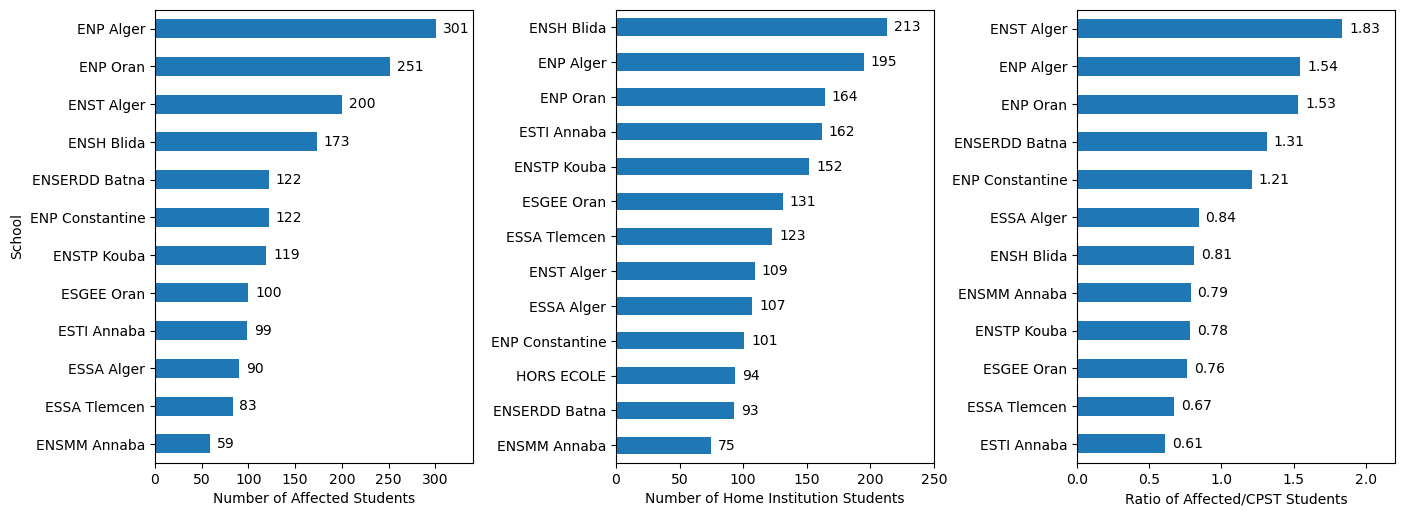

In [7]:
affected_df = df.groupby(by = "Affectation", axis = 0).count().Nom.sort_values()
original_df = df.groupby(by = "EtaOrig", axis = 0).count().Nom.sort_values()
ratio_df = (affected_df/original_df).sort_values().drop(labels = "HORS ECOLE")

fig, ax = plt.subplots(1,3, figsize = (16,6), gridspec_kw={"wspace":0.45})

affected_df.plot.barh(ax = ax[0])
ax[0].set_ylabel("School")
ax[0].set_xlabel("Number of Affected Students")
ax[0].bar_label(ax[0].containers[0], padding=5)
ax[0].set_xlim(0,340)

original_df.plot.barh(ax = ax[1])
ax[1].set_ylabel("")
ax[1].set_xlabel("Number of Home Institution Students")
ax[1].bar_label(ax[1].containers[0], padding=5)
ax[1].set_xlim(0,250)

ratio_df.plot.barh(ax = ax[2])
ax[2].set_ylabel("")
ax[2].set_xlabel("Ratio of Affected/CPST Students")
ax[2].bar_label(ax[2].containers[0], padding=5, fmt = "%0.2f")
ax[2].set_xlim(0,2.2)

plt.show()

From the above figure we see that `ENST Alger` receives almost double the students that graduated from it, in the same time `ESTI Annaba` only recieves the half.

The Figure down below shows the ranking of schools that produces top ranking students (on the left) and that recieves top ranked students (on the the right). The derived values are calculated as the mean ranking of the students. `ENP Alger` has the best ranking and also recieves the best students, this is expected since the required GPA for entrance to `ENP Alger` is quite high, and most students want to join due to its legacy.
What's surprising is tha `ENSMM Annaba` and `ENSH Blida` are ranked in the middle when it comes to the average ranking of its students however they recieves low ranked students.

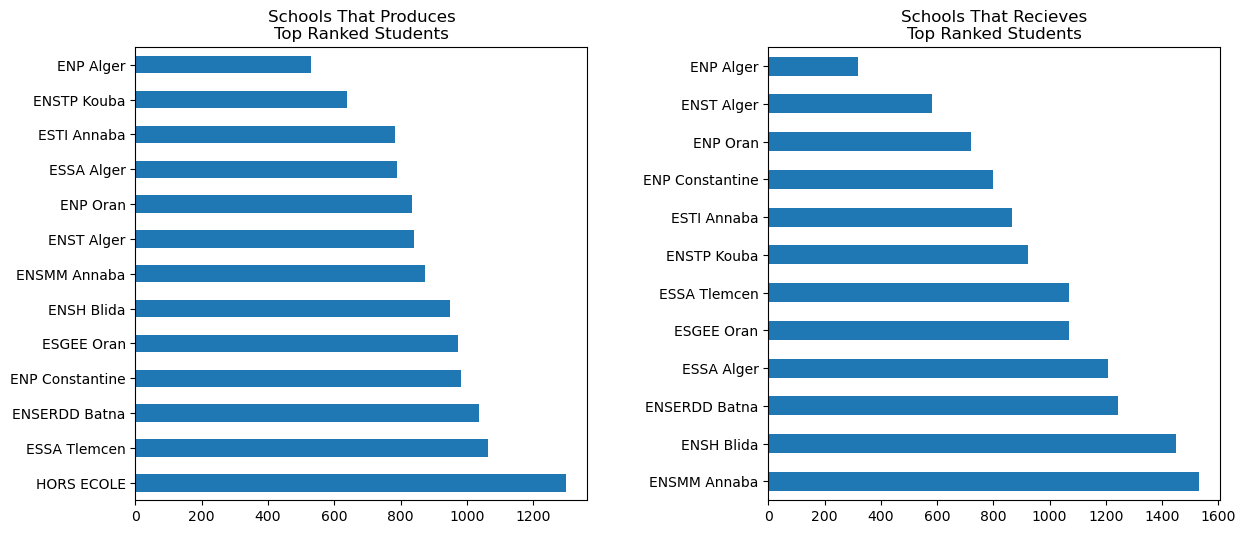

In [8]:
fig, ax = plt.subplots(1,2, figsize = (14,6), gridspec_kw={"wspace":0.4})
ranking_per_oriScholl = df.groupby(by = "EtaOrig").Classement
ranking_per_oriScholl.mean().sort_values(ascending = False).plot.barh(ax = ax[0])

ranking_per_affectedScholl = df.groupby(by = "Affectation").Classement
ranking_per_affectedScholl.mean().sort_values(ascending = False).plot.barh(ax = ax[1])


ax[0].set_title("Schools That Produces\nTop Ranked Students")
ax[0].set_ylabel("")
ax[1].set_title("Schools That Recieves\nTop Ranked Students")
ax[1].set_ylabel("")


plt.show()

To get more insight on the distribution of the students per affected/home institution, we take a look at [box plots](https://en.wikipedia.org/wiki/Box_plot).

On the lefts we see that all schools students hove similar ranking ranges, except for students who are outside of any school this might by due to the fact that these students have to prepare alone (repeating year) or they have different programs (uni students), however there are some exception (small circles on the lefts of the box) these students are quite exceptional to achieve this ranking outside of the CPST curriculum. What's puzzling for me is that `ESSA Tlemcen` have the lowest ranking mean, to my memory it used to be one of the best preparatory schools

On the right we see the difference of the student ranking, as we have seen before `ENSMM Annaba` and `ENSH Blida` have the lowest ranking students however there are some exceptions, it seems that there are some students who excplicitly chose these schools. The choise might be based on desired study field (since both schools have only few study fields) or they simply chose them for the Wilaya. On the other hand `ESSA Alger` seems to be unwanted even among it's students (as we will see later only 18% of it's students stay in the school).

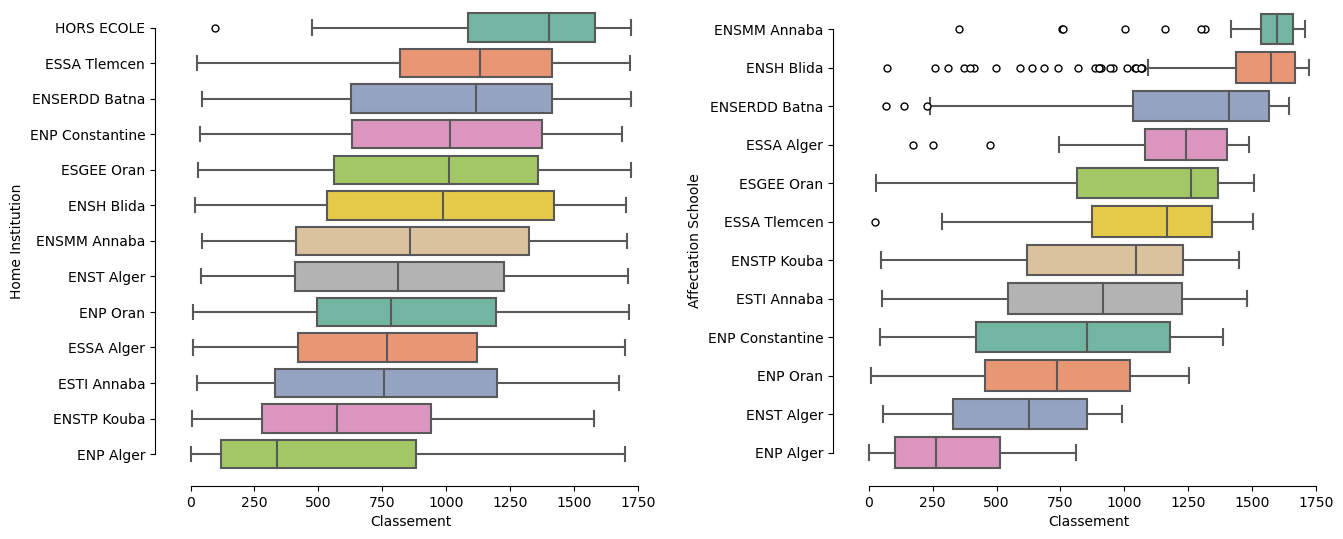

In [50]:
order = ranking_per_affectedScholl.mean().sort_values(ascending = False).index
order2 = ranking_per_oriScholl.mean().sort_values(ascending = False).index


order = np.array(order)

fig, ax = plt.subplots(1,2,figsize = (15,6), gridspec_kw={"wspace":0.4})

flierprops={"marker":"o","markerfacecolor":"white", "markeredgecolor":"k"}


sns.boxplot(y = "EtaOrig", x = "Classement", data = df, 
            order= order2, ax = ax[0],flierprops =flierprops,
            palette = sns.color_palette("Set2"))
ax[0].set_ylabel("Home Institution")


sns.boxplot(y = "Affectation", x = "Classement", data = df, 
            order= order, ax = ax[1], orient = "h",flierprops =flierprops,
            palette = sns.color_palette("Set2"))
ax[1].set_ylabel("Affectation Schoole")


sns.despine(offset=10, trim=True)
plt.show()

### Probability of Staying in the Home Insitution

In [15]:
edges = df[["EtaOrig", "Affectation", "Classement"]]
edges.columns = ["source", "target", "value"]

grouped_edges = edges.groupby(["source", "target"]).count().sort_values(by = "value", ascending = False)
grouped_edges_ri = grouped_edges.reset_index()
grouped_edges_ri
#grouped_edges_ri.to_csv("grouped_affected.csv")

labels = grouped_edges_ri.source.unique()
labels_dict = {label:i for i, label in enumerate(labels)}

grouped_edges_enum = grouped_edges_ri.replace(labels_dict)
grouped_df = edges.groupby(["source", "target"]).count()

pd.options.mode.chained_assignment = None

In [51]:
probs = []
grouped_by_schools = []
for label in labels:
    
    grouped_by_school = grouped_edges_ri[grouped_edges_ri.source == label]
    grouped_by_school.loc[:,"value"] = 100*grouped_by_school.loc[:,"value"]/grouped_by_school.loc[:,"value"].sum()
    prob_of_staying = grouped_by_school[grouped_by_school.target == label].value.values
    # print(label, "\t\t:", prob_of_staying)
    probs.append(prob_of_staying)
    grouped_by_schools.append(grouped_by_school)

In [53]:
probs[-2] = np.array([0])
probs = [float(prob) for prob in probs]

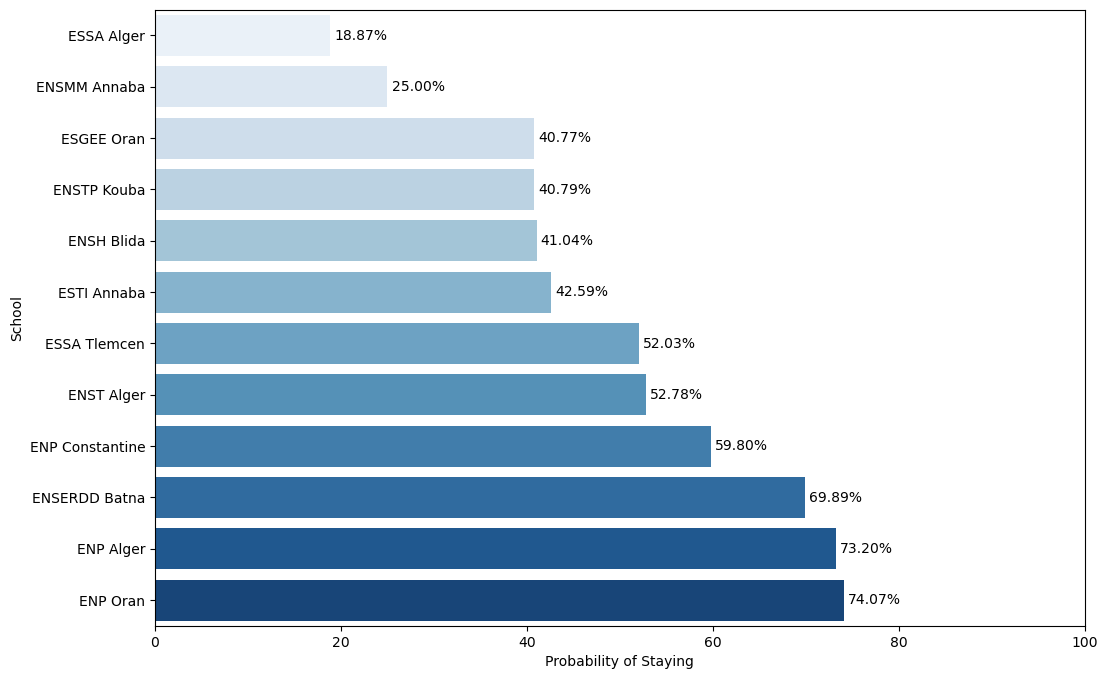

In [57]:

probs = np.array(probs).ravel()
args = np.argsort(probs)[1:]

fig, ax = plt.subplots(figsize = (12,8), dpi = 100)
sns.barplot(y = labels[args], x = probs[args], ax = ax, palette = "Blues")
ax.bar_label(ax.containers[0], label_type='edge', padding = 3, fmt = "%.2f%%")
ax.set_xlim(0,100)
ax.set_ylabel("School")
ax.set_xlabel("Probability of Staying")
plt.show()

In [17]:
heatmap_df = pd.read_csv("heatmap_concours.csv", index_col=0)
heatmap_df.fillna(0, inplace=True)

In [18]:
len(labels)

13

In [25]:
heatmap_df = heatmap_df.reindex(labels[args])
heatmap_df = heatmap_df[labels[args]]

In [26]:
heatmap_df = heatmap_df.drop("HORS ECOLE", axis = 0)

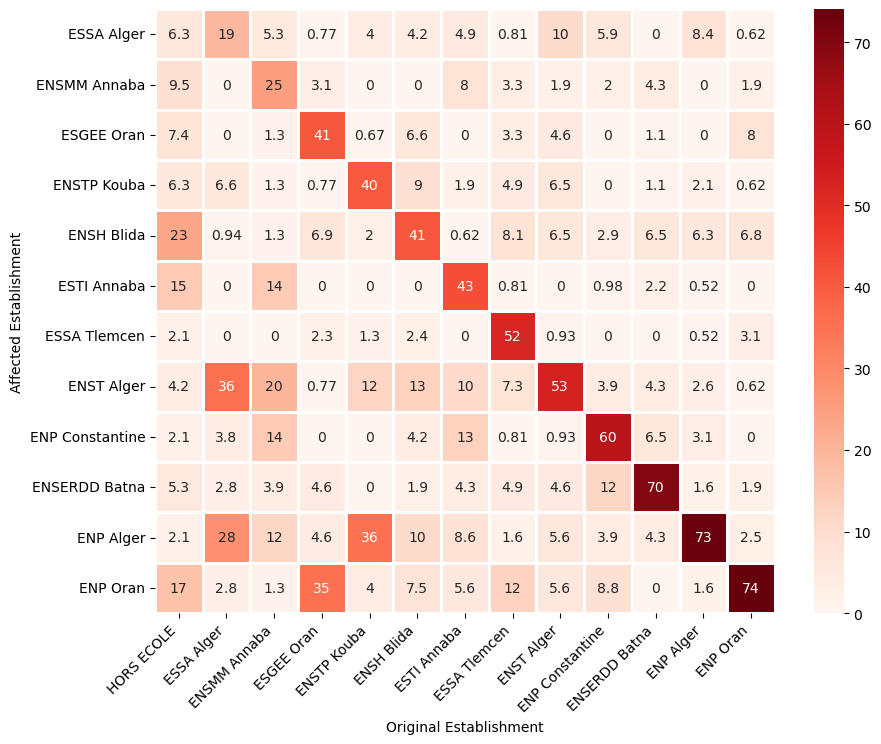

In [27]:
from matplotlib.colors import LogNorm, Normalize
fig, ax = plt.subplots(figsize = (10,8), dpi = 100)
sns.heatmap(heatmap_df, cmap = "Reds", annot = True, norm=Normalize(),
            cbar = True,
            ax = ax,
            linewidths=.8)
ax.set_xlabel("Original Establishment")
ax.set_ylabel("Affected Establishment")
plt.setp(ax.get_xticklabels(), ha="right", rotation=45)
plt.show()

 The following arguments are deprecated and should be removed: figSize in sankey()


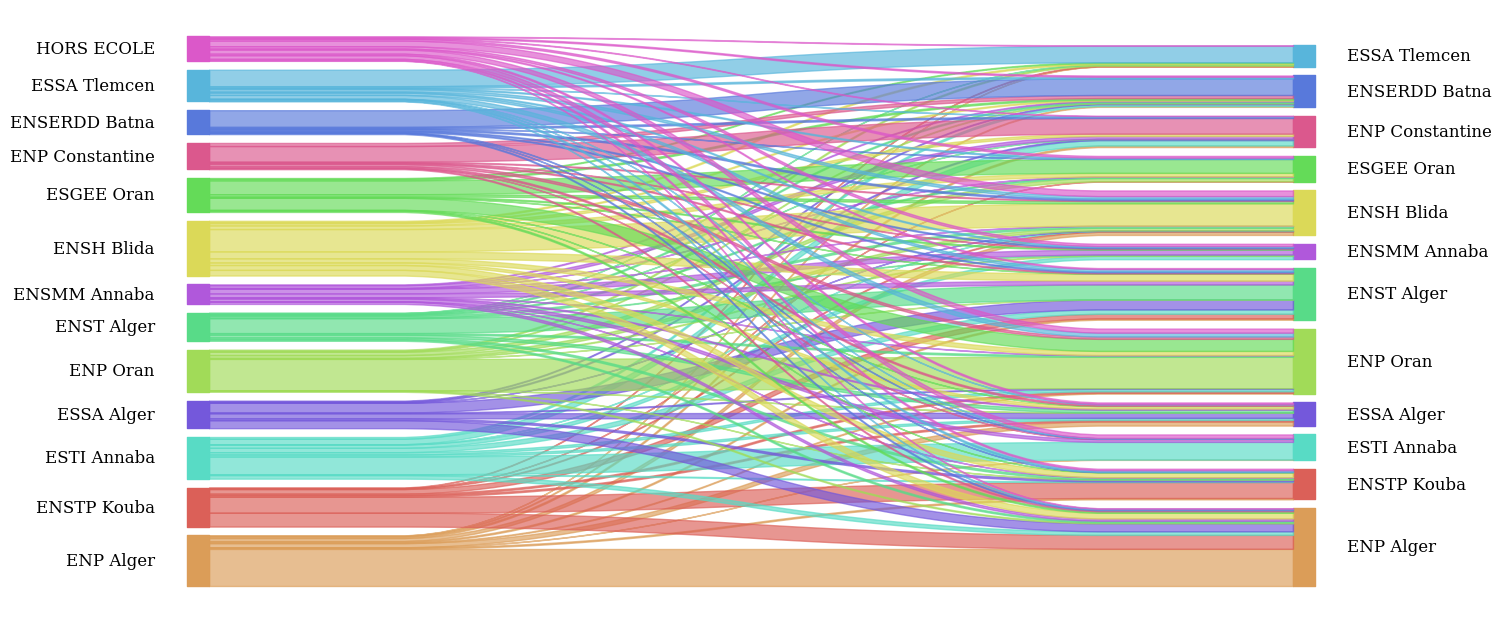

In [28]:
leftlabels = list(ranking_per_oriScholl.mean().sort_values().index.values)
rightlabels = list(ranking_per_affectedScholl.mean().sort_values().index.values)

from pysankey import sankey


ax = sankey(
    edges['source'], edges['target'], aspect=20, #colorDict=colorDict,
    leftLabels=leftlabels,
    rightLabels=leftlabels[:-1],
    fontsize=12,
    figSize = (16, 8)
)

plt.savefig("sankey_concours.png", dpi = 300)
plt.show() # to display

In [29]:
X = edges[["source", "value"]]
y = edges.target

In [30]:
X = pd.get_dummies(X)
names = X.columns

In [31]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
le.fit(y)
y = le.transform(y)

## Classification and Effect of Home Insitution and Rank on the Affected School

In [32]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegressionCV
from sklearn.svm import SVC
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler
imp = KNNImputer()
X = imp.fit_transform(X)
X = StandardScaler().fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state= 123)
clf = LogisticRegressionCV(max_iter=5000)
clf.fit(X_train, y_train)
clf.score(X_test, y_test)

0.580046403712297

In [33]:
len(le.classes_)

12

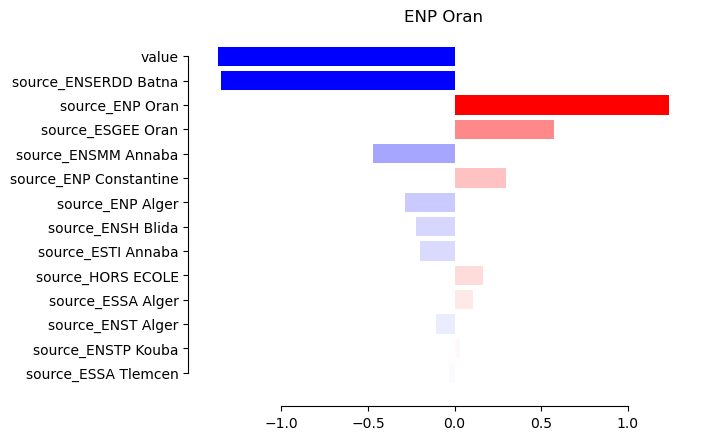

In [34]:
import matplotlib.colors as mcolors

ci = 2
plt.style.use("default")
affected_school = le.classes_[ci]
import matplotlib
lc = len(clf.coef_[ci])
coefs = clf.coef_[ci]
args = np.argsort(np.abs(coefs))

offset = mcolors.TwoSlopeNorm(vmin=coefs.min(), vcenter=0., vmax=coefs.max())
colors= offset(coefs).data
cmap = matplotlib.cm.get_cmap('bwr')
colors = [cmap(color) for color in colors]

plt.barh(range(lc), coefs[args], color = np.array(colors)[args])
plt.yticks(range(lc), names[args])
ax = plt.gca()
# Hide the right and top spines
ax.spines.right.set_visible(False)
ax.spines.top.set_visible(False)

# Only show ticks on the left and bottom spines
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')
plt.title(affected_school)
sns.despine(offset=5, trim=True)
plt.show()

In [36]:
cr_labels = list(le.classes_.astype(str))
len(cr_labels)

12

In [37]:
from sklearn.metrics import classification_report
print(classification_report(y, clf.predict(X), target_names  = cr_labels))

                 precision    recall  f1-score   support

      ENP Alger       0.67      0.75      0.71       301
ENP Constantine       0.70      0.50      0.58       122
       ENP Oran       0.67      0.67      0.67       253
  ENSERDD Batna       0.69      0.56      0.62       122
     ENSH Blida       0.60      0.77      0.68       173
   ENSMM Annaba       0.59      0.45      0.51        60
     ENST Alger       0.51      0.56      0.53       201
    ENSTP Kouba       0.46      0.37      0.41       119
     ESGEE Oran       0.46      0.33      0.39       100
     ESSA Alger       0.54      0.34      0.42        90
   ESSA Tlemcen       0.56      0.73      0.64        83
    ESTI Annaba       0.52      0.67      0.58        99

       accuracy                           0.60      1723
      macro avg       0.58      0.56      0.56      1723
   weighted avg       0.60      0.60      0.59      1723



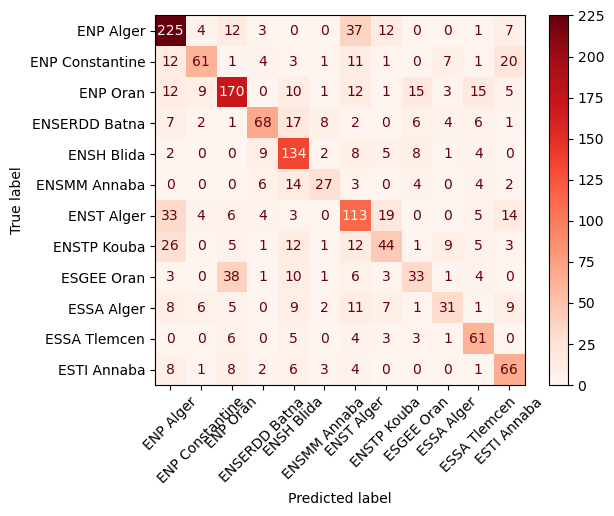

In [38]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
plt.style.use("default")
cm = confusion_matrix(y, clf.predict(X))
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                               display_labels=le.classes_)
disp.plot(cmap = "Reds", xticks_rotation = 45)
plt.show()


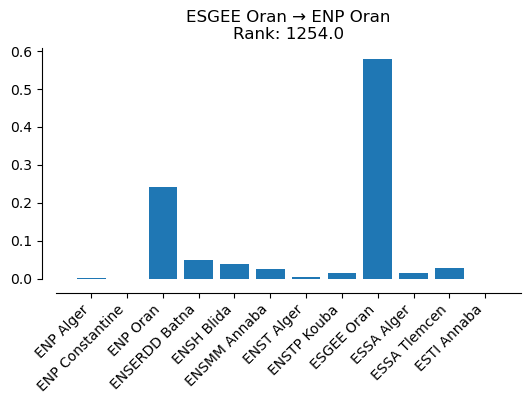

In [39]:
person_rn = np.random.randint(0,len(X))
ps = clf.predict_proba(X[person_rn].reshape(1,-1)).ravel()
person = df[["Affectation", "EtaOrig", "Classement"]].iloc[person_rn,:]
txt_args = person.values
text = txt_args[1]+" → "+txt_args[0]+"\nRank: "+str(txt_args[2])
plt.figure(figsize = (6,3))
plt.bar(range(12), ps)
sns.despine(trim = False, offset=10)
plt.xticks(range(12), le.classes_, rotation = 45, ha = "right")
plt.title(text)
plt.show()